In [1]:
from ipywidgets import interact, fixed, IntSlider, FloatSlider
from skimage.morphology import dilation, square
from skimage.color import rgb2gray, rgb2hsv
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import cv2


In [2]:
from python_files.hough_transform_module import Hough
from python_files.sliding_window_module import SlidingWindow
from python_files.preprocessing_functions import crop_half, plot_images, gray_to_binary

## Read video

In [3]:
# read the first frame of the video and store it
vidcap = cv2.VideoCapture("Videos/LaneVideo.mp4")
success, frame = vidcap.read()

## Resize frame & convert to gray

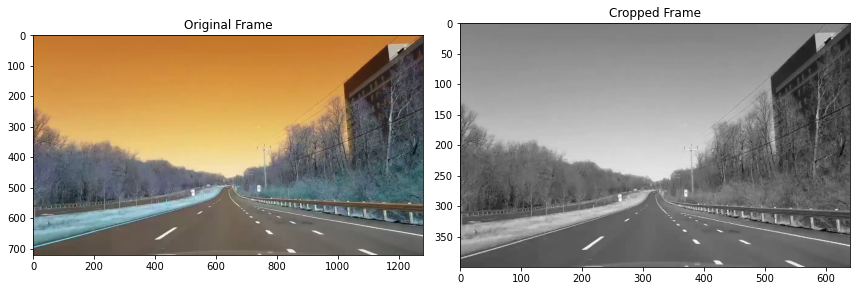

In [4]:
resized_frame = cv2.resize(frame, (640, 400))
gray_resized_frame = rgb2gray(resized_frame)
plot_images(frame, gray_resized_frame, "Original Frame", "Cropped Frame", cmap2='gray')

## Apply prespective transformation

In [5]:
H, W = gray_resized_frame.shape

In [6]:

# Initial parameters
bottom_width = int(W/8)
top_width = int(W/5)
vertical_position = int(H/2)
line_distance = int(H/5)
horizontal_position = int(W/2)

p1 = np.zeros((2, 1))
p2 = np.zeros((2, 1))
p3 = np.zeros((2, 1))
p4 = np.zeros((2, 1))

# Function to update the plot based on the slider values
def update_trapezoid(img, bottom_width, top_width, vertical_position, line_distance,
                     horizontal_position, rotation, line_distance1):
    global p1, p2, p3, p4
    # Convert degrees to radians for rotation
    theta_cw = np.radians(rotation)
    
    # update points based on sliders values
    x1 = horizontal_position - bottom_width / 2
    x2 = horizontal_position + bottom_width / 2
    x4 = horizontal_position - top_width / 2
    x3 = horizontal_position + top_width / 2
    y1 = vertical_position - line_distance1
    y2 = vertical_position - line_distance1
    y4 = vertical_position + line_distance
    y3 = vertical_position + line_distance
    
    # Rotation matrix for clockwise and counterclockwise rotation
    rot = np.array([[np.cos(theta_cw), -np.sin(theta_cw)],
                       [np.sin(theta_cw), np.cos(theta_cw)]])
    
    # Apply rotation transformation to trapezoid vertices
    p1 = np.dot(rot, np.array([[x1], [y1]]))
    p2 = np.dot(rot, np.array([[x2], [y2]]))
    p3 = np.dot(rot, np.array([[x3], [y3]]))
    p4 = np.dot(rot, np.array([[x4], [y4]]))
    pts = np.array([p1, p2, p3, p4])
    
    # Plot the rotated trapezoid
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.plot([p1[0], p2[0], p3[0], p4[0], p1[0]], [p1[1], p2[1], p3[1], p4[1], p1[1]], 'b-')
    plt.scatter(pts[:, 0], pts[:, 1], color=['red', 'blue', 'green', 'yellow'])
    plt.ylim(H, 0)
    plt.xlim(0, W)
    plt.show()

# Create sliders for controlling the trapezoid parameters and rotation angles
interact(update_trapezoid,
         img=fixed(gray_resized_frame),
         bottom_width=FloatSlider(min=1, max=W, step=0.1, value=77, description='Top Width:'),
         top_width=FloatSlider(min=1, max=W, step=0.1, value=370, description='Bottom Width:'),
         vertical_position=FloatSlider(min=1, max=H, step=0.1, value=310, description='Vertical Position:'),
         line_distance=FloatSlider(min=1, max=H, step=0.1, value=80, description='Line Distance:'),
         horizontal_position=FloatSlider(min=0, max=W, step=0.1, value=310, description='Horizontal Position:'),
         rotation=FloatSlider(min=-360, max=360, step=2, value=0, description='Rotation (degrees):'),
         line_distance1=FloatSlider(min=1, max=H, step=0.1, value=line_distance-100, description='Line Distance1:'),
         
        )


interactive(children=(FloatSlider(value=77.0, description='Top Width:', max=640.0, min=1.0), FloatSlider(value…

<function __main__.update_trapezoid(img, bottom_width, top_width, vertical_position, line_distance, horizontal_position, rotation, line_distance1)>

In [7]:
def perspective_transformation(img, pts_source):
        """Returns perspective transformation of an image."""
        if(len(img.shape) == 2):
                H, W = img.shape
        else:
                H, W, _ = img.shape
                
        # Define source points, points are defined as (col, row)
        d_top_left = (0, 0)
        d_top_right = (W-1, 0)
        d_bottom_left = (0, H - 1)
        d_bottom_right = (W - 1, H - 1)
        
        pts_destination = np.array([d_top_left, d_top_right, d_bottom_right, d_bottom_left], dtype=np.float32)
        
        # Get perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(pts_source, pts_destination)
        
        # Apply perspective transformation
        transformed_img = cv2.warpPerspective(img, matrix, (W, H))
        return transformed_img, matrix

In [8]:
pts_source = np.array([p1, p2, p3, p4], dtype=np.float32).reshape(4, 2)
transformed_img, matrix = perspective_transformation(gray_resized_frame, pts_source)

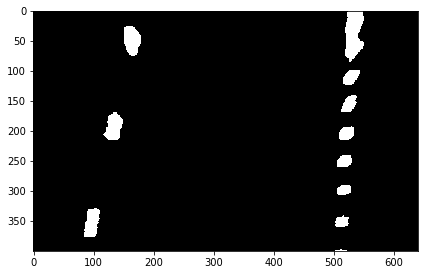

In [9]:
binary_frame = gray_to_binary(transformed_img)
io.imshow(binary_frame)
plt.show()

# Morphological operation

In [10]:
eroded_img = None
def apply_erosion_test(img, element_size):
    """Applies opening morphological operation."""
    global eroded_img
    
    # Define the structuring element for the morphology operation (kernel)
    kernel = np.ones((element_size, element_size), np.uint8)  # Adjust the kernel size as needed

    # Perform closing on the grayscale image
    eroded_img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)

    # Display the opened image
    plt.figure(figsize=(6, 6))
    plt.imshow(eroded_img, cmap='gray')
    plt.title(f'Morphological Opening (Element Size: {element_size})')
    plt.show()


# Create a slider for the element size parameter
element_size_slider = IntSlider(min=1, max=50, step=1, value=10, description='Element Size')

# Create the interactive widget
interact(apply_erosion_test, img=fixed(binary_frame), element_size=element_size_slider);    

interactive(children=(IntSlider(value=10, description='Element Size', max=50, min=1), Output()), _dom_classes=…

# Hough Transform

In [11]:
hough_ = Hough(5, 200)

In [12]:
r1, theta1, r2, theta2 = hough_.get_polar_coorindates(eroded_img)
lane_mask = hough_.get_mask(eroded_img, r1, theta1, r2, theta2)
print(r1,r2)

536 161


# Inverse Perspective Transformation

In [13]:
def inv_perspective_transform(inv_frame, t_matrix, W, H):
    """Applies Inverse Perspective Transformation on a transformed frame."""
    inv_t_matrix= np.linalg.inv(t_matrix)
    frame = cv2.warpPerspective(inv_frame, inv_t_matrix, (W, H))
    return frame

In [14]:
H, W, _ = lane_mask.shape
inv_lanes_mask = inv_perspective_transform(lane_mask, matrix, W, H)

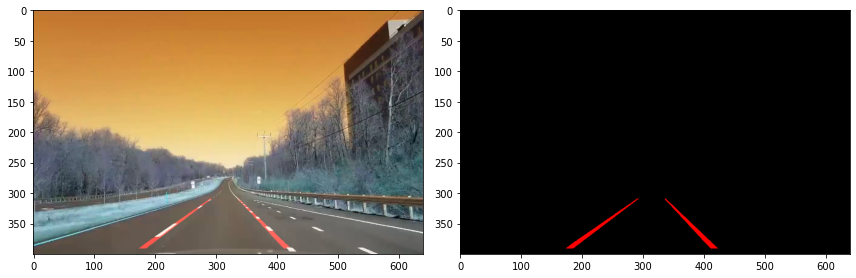

In [15]:
inv_lanes_mask[:, :, 1] = dilation(inv_lanes_mask[:, :, 1], square(5))
resized_frame[:, :, 0] = np.maximum(resized_frame[:, :, 0], inv_lanes_mask[:, :, 0])

plot_images(resized_frame, inv_lanes_mask, "", "")

# Hough transform PipeLine

In [16]:
def lane_detection_pipeline(video_path, algorithm):
    video = cv2.VideoCapture(video_path)
    if(algorithm == "hough"):
        model = Hough(5, 250)
    else:
        model = SlidingWindow(30, 30)
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        
        # crop image using the following dimensions 
        resized_frame = cv2.resize(frame, (640, 400))
        gray_resized_frame = rgb2gray(resized_frame)
            
        # apply Prespective transformation
        transformed_img, matrix = perspective_transformation(gray_resized_frame, pts_source)            
            
        # convert to binary
        binary_frame = gray_to_binary(transformed_img)
    
        # add morphological opeations if needed
        # Define the structuring element for the morphology operation (kernel)
        kernel = np.ones((8, 8), np.uint8)  # Adjust the kernel size as needed

        # Perform erode on the binary image
        eroded_img = cv2.morphologyEx(binary_frame, cv2.MORPH_ERODE, kernel)

        if(i % 4 == 0):   
            # apply hough transfomration
            if(algorithm == 'hough'):
                r1, theta1, r2, theta2 = model.get_polar_coorindates(eroded_img)
                lanes_mask = model.get_mask(eroded_img, r1, theta1, r2, theta2)
            else:
                lanes_mask = model.get_mask(eroded_img)

        # apply inverse prespective transform
        H, W, _ = lanes_mask.shape
        inv_lanes_mask = inv_perspective_transform(lanes_mask, matrix, W, H)
        
        # add mask to the original frame
        resized_frame = cv2.addWeighted(resized_frame, 1, inv_lanes_mask, 0.8, 0)
        # resized_frame[:, :, 0] = np.maximum(resized_frame[:, :, 0], inv_lanes_mask[:, :, 0])

        i += 1
    
        # Display the frame
        cv2.imshow('Video Player', resized_frame)
        cv2.imshow('perspective transformation', eroded_img)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Release resources
    video.release()
    cv2.destroyAllWindows()

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


TypeError: expected non-empty vector for x

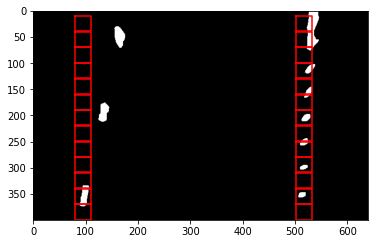

In [17]:
%time lane_detection_pipeline('Videos/LaneVideo.mp4', "slidingWindow")

In [ ]:
sw = SlidingWindow(50, 50)
l, r , hist = sw.get_lanes_starting_points(eroded_img, True)

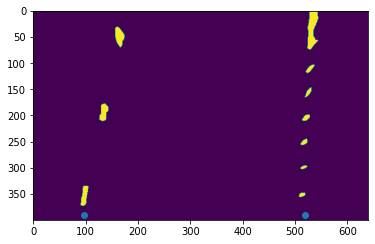

In [ ]:
plt.imshow(eroded_img)
plt.scatter([l ,r], [390, 390])

In [ ]:
l

96

# Get the Lanes x-coordinates

In [ ]:
def Get_lanes_bases(img):

    # Get the Histogram of the bottom half of the frame captured
    half_frame = img.shape[0] //4

    crop_half_frame = img[half_frame:,:]
    axis_Histogram = np.sum(crop_half_frame,axis = 0)

    # Get where is the max values located on the x-axis
    left_lane = np.argmax(axis_Histogram[:img.shape[1]//2])
    right_lane = (img.shape[1]//2) + np.argmax(axis_Histogram[img.shape[1]//2:]) 

    return left_lane, right_lane


# Sliding window

In [ ]:
def sliding_window(img, imgHeight, window_height, window_width, original_img):

    left_lane, right_lane = Get_lanes_bases(img)
    msk = original_img.copy()
    # Arrays to hold the lane index
    x_left = []
    x_right = []

    left_y = []
    right_y = []
    
    # Creating the window on the lanes bases
    num_of_windows = imgHeight//window_height
    
    # Move the window on the lane
    for i in range(num_of_windows):
    
        left_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(left_lane) - window_width//2:int(left_lane) + window_width//2]
        right_lane_win = img[imgHeight -(i+1)*window_height:imgHeight - i*window_height, int(right_lane) - window_width//2:int(right_lane) + window_width//2]

        cv2.rectangle(msk, (int(left_lane) - window_width//2,imgHeight -(i+1)*window_height), (int(left_lane) + window_width//2,imgHeight - i*window_height), (255,255,255), 2)
        cv2.rectangle(msk, (int(right_lane) - window_width//2,imgHeight -(i+1)*window_height), (int(right_lane) + window_width//2,imgHeight - i*window_height), (255,255,255), 2)
        # get the white pixels in the left and right window
        left_non_zero = np.argwhere(left_lane_win > 0)
        right_non_zero = np.argwhere(right_lane_win > 0)

        # Check if the window has no lane pixels
        if not ((left_non_zero.any() > 0) and (right_non_zero.any() > 0)):
            continue

        # add the index to the lane arrays
        left_new_index = left_non_zero[:,1] + max(0,(left_lane - window_width//2))
        right_new_index = right_non_zero[:,1] + max(0,(right_lane - window_width//2))

        # Lanes Y index
        left_y.append(imgHeight - i*window_height)
        right_y.append(imgHeight - i*window_height)

        # update the window base
        left_lane = np.mean(left_new_index)
        right_lane = np.mean(right_new_index)

        x_left.append(left_lane)
        x_right.append(right_lane)

    
    return x_left, x_right, left_y, right_y , msk


In [ ]:
def curve_fitting(x_left, x_right, left_y, right_y):
    
    # Curve fitting(2nd degree poynomial) for the points from the window
    left_curve = np.polyfit(x_left, np.array(left_y), 2)
    right_curve = np.polyfit(x_right, np.array(right_y), 2)

    return left_curve, right_curve


# Get Curvature

In [ ]:
def get_Curvature(left_curve, right_curve, img_h, y_meter_per_pixel= 15/350, x_meter_per_pixel = 3.7/500, y_value = 150 ):

    # polynomial fitting = Ax^2 + Bx + C
    A_left, B_left, C_left = left_curve
    A_right, B_right, C_right = right_curve

    # If A = -ve , then the direction of curvature is at the left & vice-versa
    if (A_left and A_right) > 0:
        direction = 'right'
    elif (A_left and A_right) < 0:
        direction = 'left'
    else:
        direction = 'straight'

    # Radius of curvature = ((1 + (2Ax + B)**2)**(3/2)) / |2A|
    left_curve = []
    right_curve = []

    # Getting the radius of curvature of set of points on the curves 

    # Map unit of coefficients and locaiton from pixel to meter
    A_l = x_meter_per_pixel / (y_meter_per_pixel**2) * A_left
    B_l = x_meter_per_pixel / y_meter_per_pixel * B_left

    A_r = x_meter_per_pixel / (y_meter_per_pixel**2) * A_right
    B_r = x_meter_per_pixel / y_meter_per_pixel * B_right
   

    # Get the mean values 
    L_curvature = ((1 + (2 * A_l * y_value * y_meter_per_pixel + B_l)**2)**1.5) / np.abs(2 * A_l)
    R_curvature = ((1 + (2 * A_r * y_value * y_meter_per_pixel + B_r)**2)**1.5) / np.abs(2 * A_r)

    return direction, L_curvature, R_curvature